# CAMB and HEALpy examples

This notebook is intended to help start CAMB and Healpy.

For more information on CAMB, see the official Document:
<br>
https://camb.readthedocs.io/en/latest/
<br>
as well as the demo file:
<br>
https://camb.readthedocs.io/en/latest/CAMBdemo.html

For more information about Healpy, see the official Document:
https://healpy.readthedocs.io/en/latest/index.html

The focus of this document is to highlight the dark-energy effect on the CMB power spectrum.

4 July 2024<br>
Donghui Jeong

In [7]:
# use ! when writing command lines in Jupyter
#!pip install --upgrade pip
#!pip install --user healpy
#!pip install --user camb

SyntaxError: invalid syntax (366980378.py, line 5)

In [1]:
import sys, os

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [2]:
import camb
from camb import model, initialpower

In [3]:
import healpy as hp

In [4]:
# Use the provided planck2018 initial file
planck2018pars = camb.read_ini("planck_2018.ini")
# camb.get_results uses params given to return CAMBdata
planck2018 = camb.get_results(planck2018pars)

In [5]:
# get the power spectrum
# returns l(l+1)C_l/2pi
powers = planck2018.get_cmb_power_spectra(planck2018pars, CMB_unit="muK")

# total power spectrum
aCl_Total = powers["total"]
# unlensed power spectrum for scalar perturbations
aCl_nolens = powers["unlensed_scalar"]

# l starts from 0 (monopole)
lmax = aCl_Total.shape[0] - 1
# l steps
aL = np.arange(lmax + 1)

In [6]:
print(powers.keys())

dict_keys(['total', 'unlensed_scalar', 'unlensed_total', 'lensed_scalar', 'tensor', 'lens_potential'])


In [12]:
print(aCl_Total.shape)
# gives Cl modes for each mode
# order: TT, EE, BB, TE

(2601, 4)


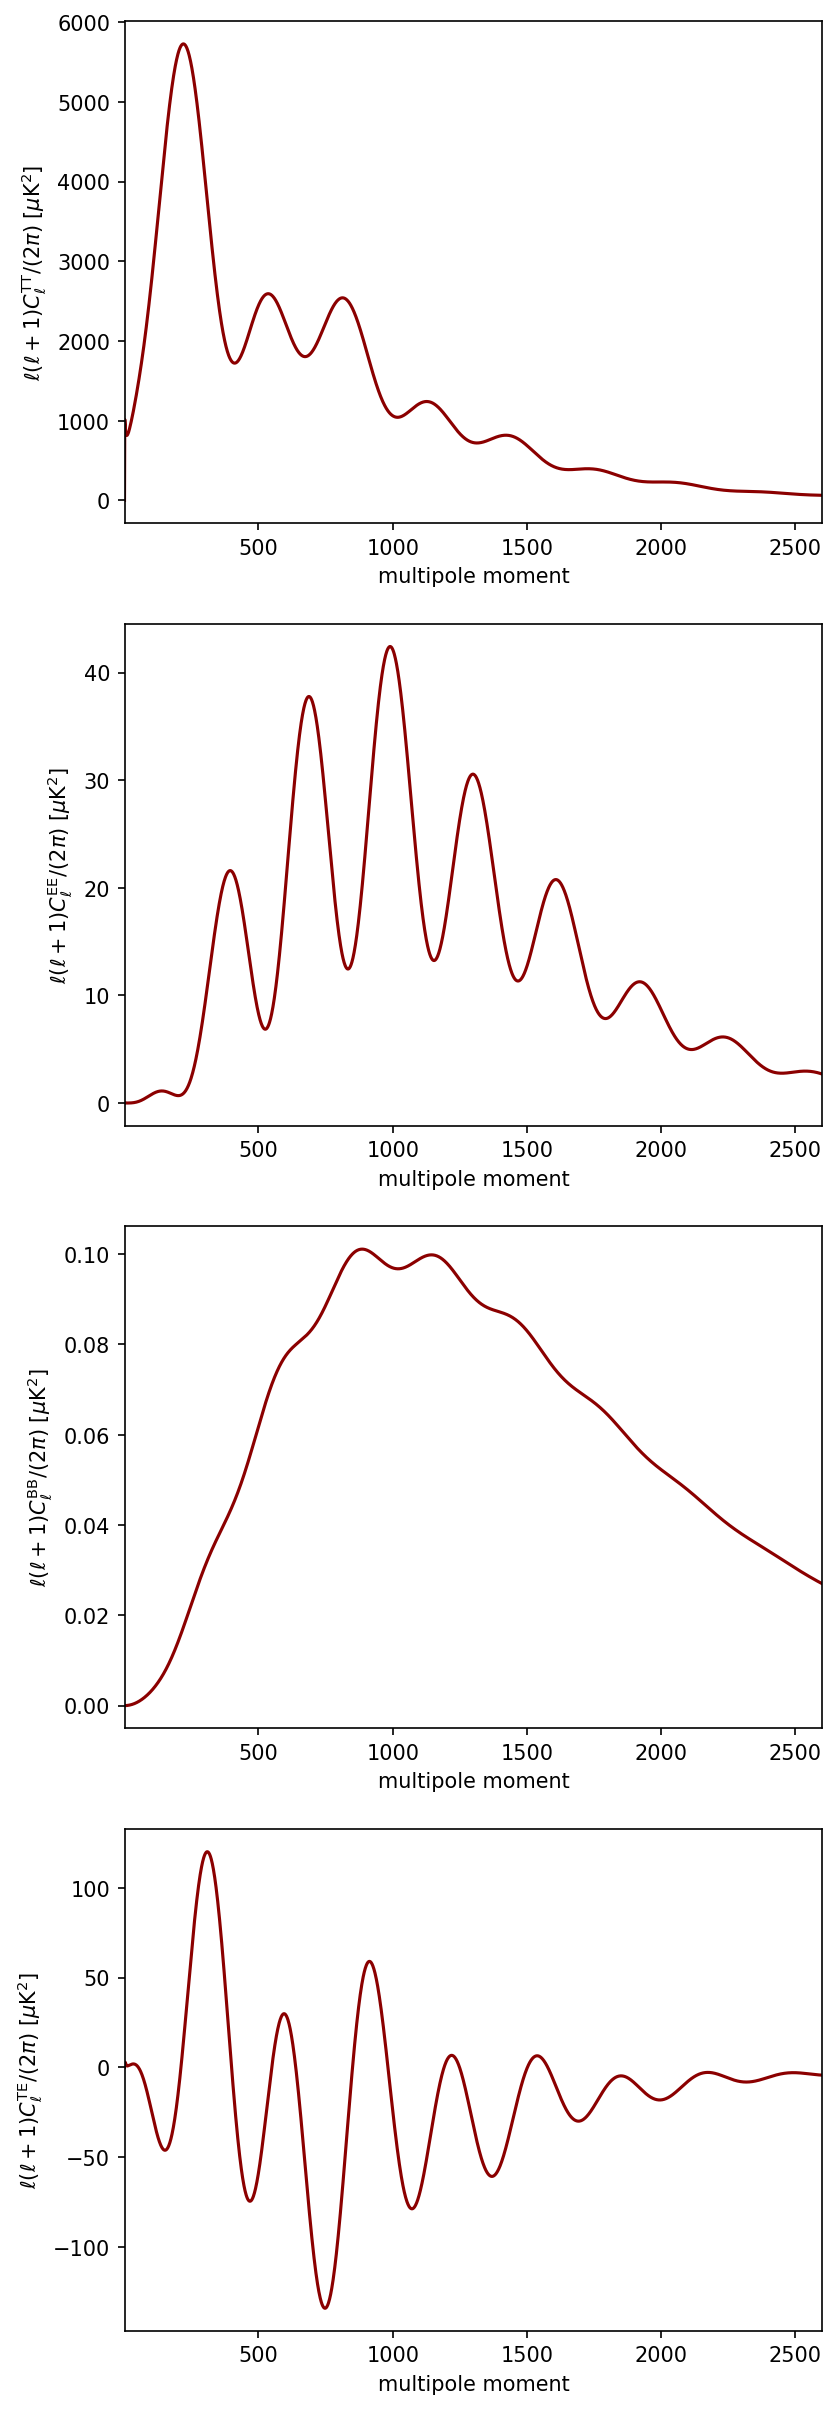

In [7]:
# Plot the temperature power spectrum
fig = plt.figure(figsize=(6, 20), dpi=150)
for pindx, ll in zip(range(4), ["TT", "EE", "BB", "TE"]):
    ax = fig.add_subplot(4, 1, pindx + 1)
    # starting from dipole onwards
    ax.set_xlim(2, lmax)
    ax.set_xlabel("multipole moment")
    ax.set_ylabel("$\ell(\ell+1)C_\ell^{\\rm " + ll + "}/(2\pi)$ [$\mu{\\rm K}^2$]")
    ax.plot(aL, aCl_Total[:, pindx], c="DarkRed")

# it will look different from planck documentation as that has a combination of log and linear scale
# BB non zero due to lensing rotating E mode polarisations

In [8]:
# Generate the random alm "TT","EE","BB","TE" perturbation coefficients for given l,m
# Cl^T = aCl_nolens[:,0]/aL/(aL+1)*2*np.pi to remove normalisation
# aL starts at 0 so will get errors for monopole
# set monopole and dipole as 0
aClTT = aCl_nolens[:, 0] / aL / (aL + 1) * 2 * np.pi
aClTT[0] = 0
aClTT[1] = 0
aClEE = aCl_nolens[:, 1] / aL / (aL + 1) * 2 * np.pi
aClEE[0] = 0
aClEE[1] = 0
aClBB = aCl_nolens[:, 2] / aL / (aL + 1) * 2 * np.pi
aClBB[0] = 0
aClBB[1] = 0
aClTE = aCl_nolens[:, 3] / aL / (aL + 1) * 2 * np.pi
aClTE[0] = 0
aClTE[1] = 0

/var/folders/xr/8_fm0nn90x74x5n0j96glblw0000gn/T/ipykernel_93159/3245012556.py:5: RuntimeWarning: invalid value encountered in divide
  aClTT = aCl_nolens[:, 0] / aL / (aL + 1) * 2 * np.pi
/var/folders/xr/8_fm0nn90x74x5n0j96glblw0000gn/T/ipykernel_93159/3245012556.py:8: RuntimeWarning: invalid value encountered in divide
  aClEE = aCl_nolens[:, 1] / aL / (aL + 1) * 2 * np.pi
/var/folders/xr/8_fm0nn90x74x5n0j96glblw0000gn/T/ipykernel_93159/3245012556.py:11: RuntimeWarning: invalid value encountered in divide
  aClBB = aCl_nolens[:, 2] / aL / (aL + 1) * 2 * np.pi
/var/folders/xr/8_fm0nn90x74x5n0j96glblw0000gn/T/ipykernel_93159/3245012556.py:14: RuntimeWarning: invalid value encountered in divide
  aClTE = aCl_nolens[:, 3] / aL / (aL + 1) * 2 * np.pi


In [20]:
print(aCl_nolens[:, 3])

[ 0.          0.          2.62105283 ... -5.08459344 -5.10733924
 -5.12932787]


In [9]:
# put into healpix need to put data in correct order (new=True)
# synalm generates alm coefficients for a given power spectrum
alms_T, alms_E, alms_B = hp.synalm(
    [aClTT, aClEE, aClBB, aClTE],
    lmax=2000,
    new=True,
)

In [10]:
# generate the map
# nside is map resolution which has to be a power of 2
TQU_maps = hp.alm2map([alms_T, alms_E, alms_B], lmax=2000, nside=512)
# T,Q,U map
T_map = TQU_maps[0]
Q_map = TQU_maps[1]
U_map = TQU_maps[2]

In [11]:
# finding range of values to define range
print(np.min(T_map), np.max(T_map))
print(np.min(Q_map), np.max(Q_map))
print(np.min(U_map), np.max(U_map))

-545.6339999389179 540.3715191070502
-22.37130341485484 22.838201719326648
-23.09871540511115 22.373724802337463


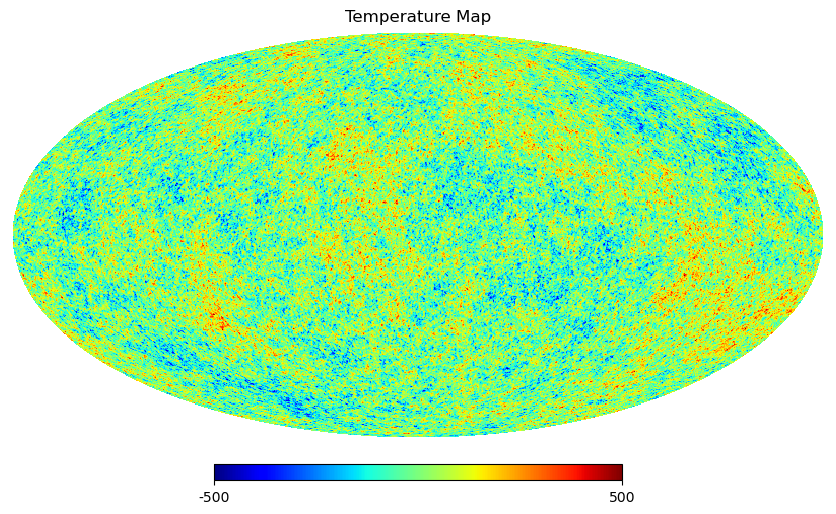

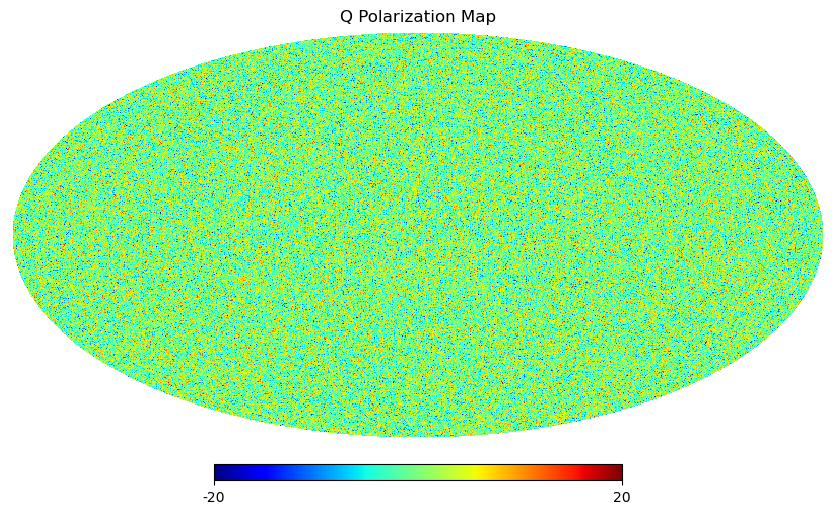

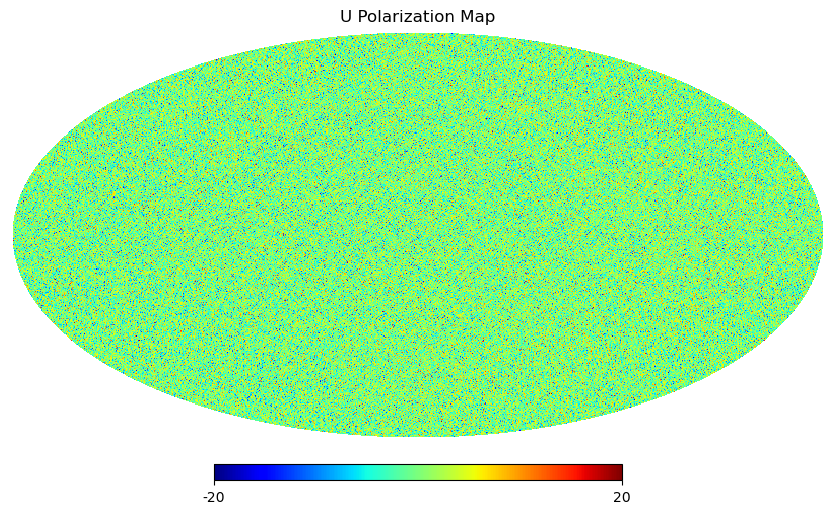

In [12]:
# generating a map of T,Q,U from Power spectrum with no lensing no tensor perturbations
hp.mollview(T_map, max=500, min=-500, cmap="jet", title="Temperature Map")
hp.mollview(Q_map, max=20, min=-20, cmap="jet", title="Q Polarization Map")
hp.mollview(U_map, max=20, min=-20, cmap="jet", title="U Polarization Map")

In [13]:
# converting the generated coefficients back to a power spectra to check from l=0 to l=2000
aCl_check = hp.alm2cl([alms_T, alms_E, alms_B])
aL2000 = np.arange(2001)

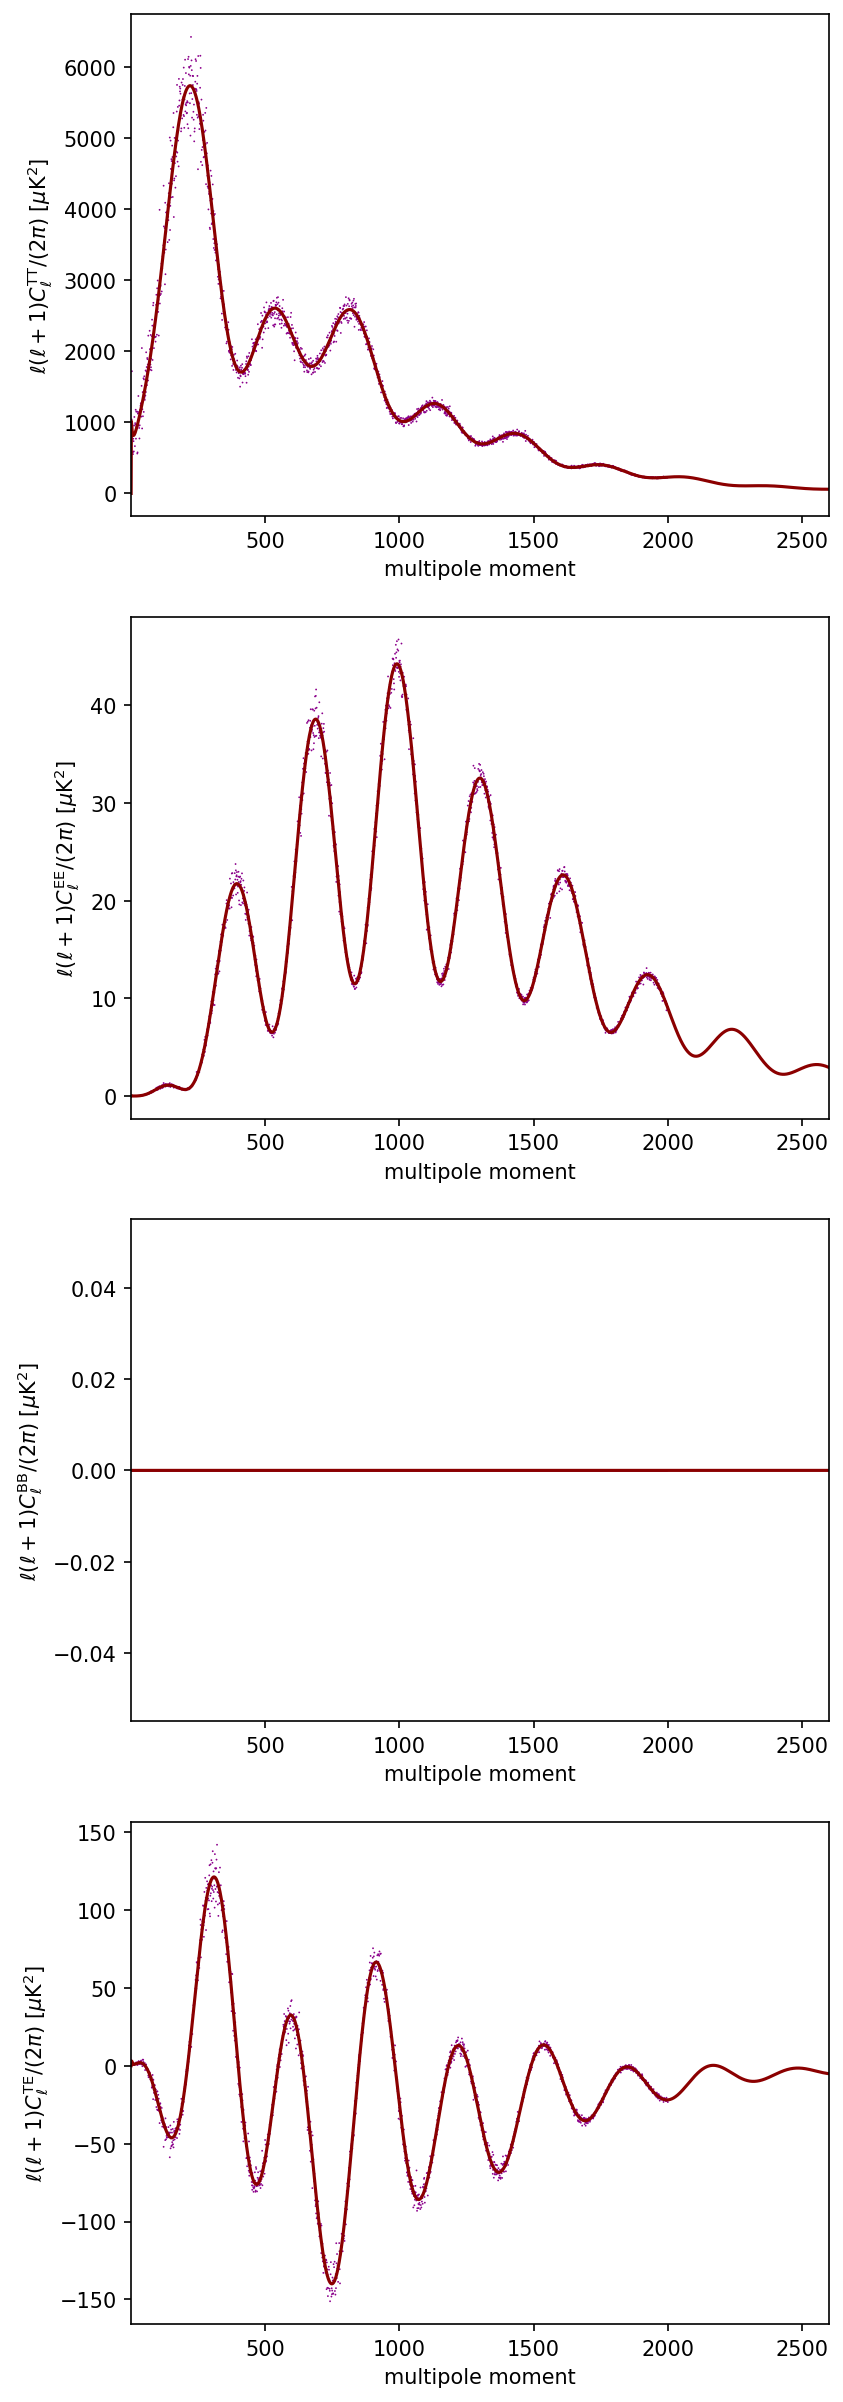

In [14]:
# Plot the temperature power spectrum
fig = plt.figure(figsize=(6, 20), dpi=150)
for pindx, ll in zip(range(4), ["TT", "EE", "BB", "TE"]):
    ax = fig.add_subplot(4, 1, pindx + 1)
    ax.set_xlim(2, lmax)
    ax.set_xlabel("multipole moment")
    ax.set_ylabel("$\ell(\ell+1)C_\ell^{\\rm " + ll + "}/(2\pi)$ [$\mu{\\rm K}^2$]")

    # aDl check this gives points for normalised values of Cl
    aDl_check_this = aCl_check[pindx] * aL2000 * (aL2000 + 1) / (2 * np.pi)
    ax.scatter(aL2000, aDl_check_this, marker=".", s=3, ec=None, c="DarkMagenta")
    # dots are random realisations

    # drawing line of camb generated no lens power spectrum
    ax.plot(aL, aCl_nolens[:, pindx], c="DarkRed")

# BB =0 as we used non lensed initial conditions to generate data

In [15]:
# Cl from the map (temperature)
aCl_out = hp.anafast(T_map, lmax=2000)
# finds power spectrum from the generated map temperature data

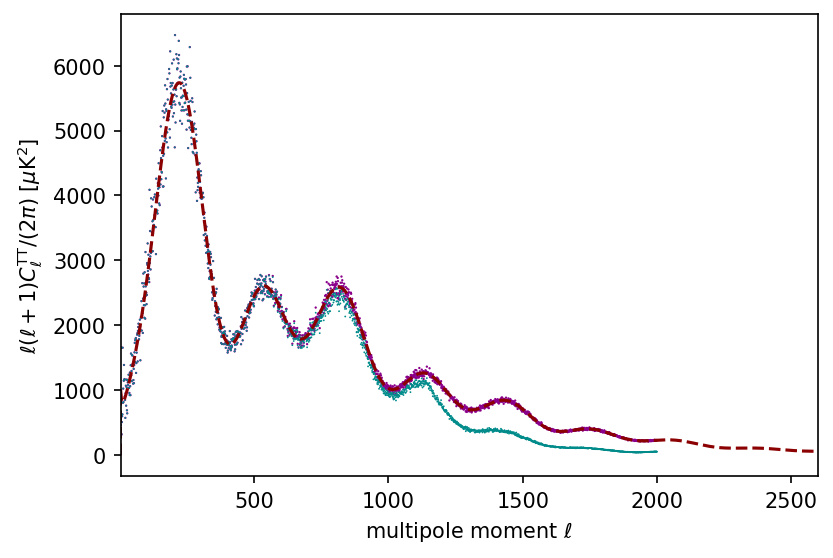

In [21]:
# Plot the temperature power spectrum
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim(2, lmax)
ax.set_xlabel("multipole moment $\ell$")
ax.set_ylabel("$\ell(\ell+1)C_\ell^{\\rm TT}/(2\pi)$ [$\mu{\\rm K}^2$]")

# aCl_check was the Cl from the generated coefficients and 0 in the temperature spectrum
# aDl is the normalised power spectrum
aDl_check = aCl_check[0] * aL2000 * (aL2000 + 1) / (2 * np.pi)
# plot of Cl from the generated coefficients
ax.scatter(aL2000, aDl_check, marker=".", s=5, ec=None, c="DarkMagenta")

# aCl_out is the Cl from the temperature map
aDl_out = aCl_out * aL2000 * (aL2000 + 1) / (2 * np.pi)

# plot of the Cl from healpix map
ax.scatter(aL2000, aDl_out, marker=".", s=3, ec=None, c="DarkCyan")
# line plot of the original no lens data generated from camb
ax.plot(aL, aCl_nolens[:, 0], c="DarkRed", ls="--")
# different at large scales due to map resolution